In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
import poppy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3
import adefc_vortex.scoob_model as scoobm

wavelength = 633e-9

/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [74]:
fname = f'data/fpm_pr_data.pkl'

fit_ref = utils.load_pickle(fname)

383 382 109


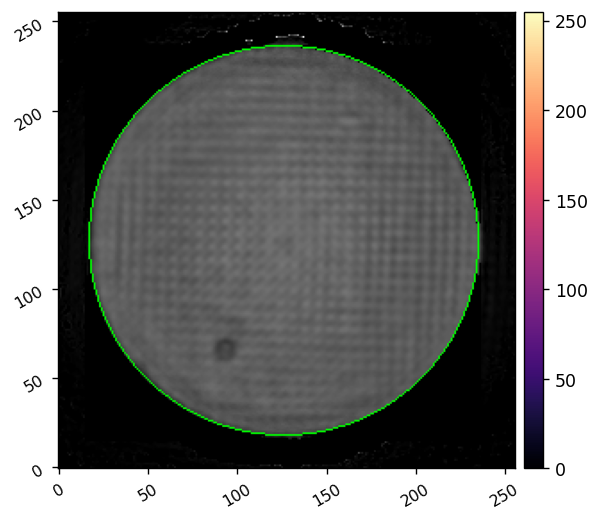

382 382 108


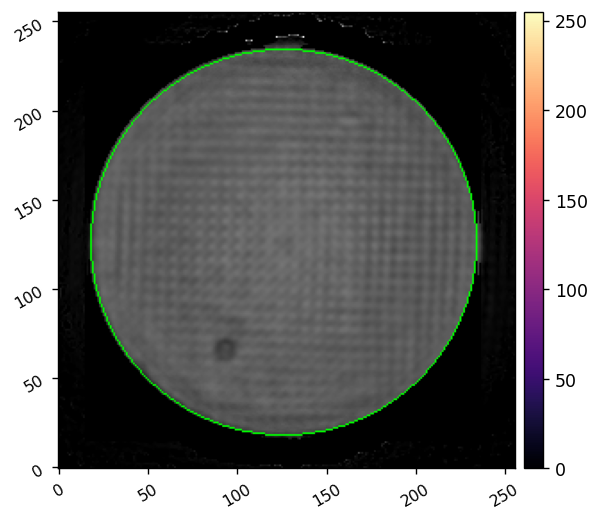

383 383 110


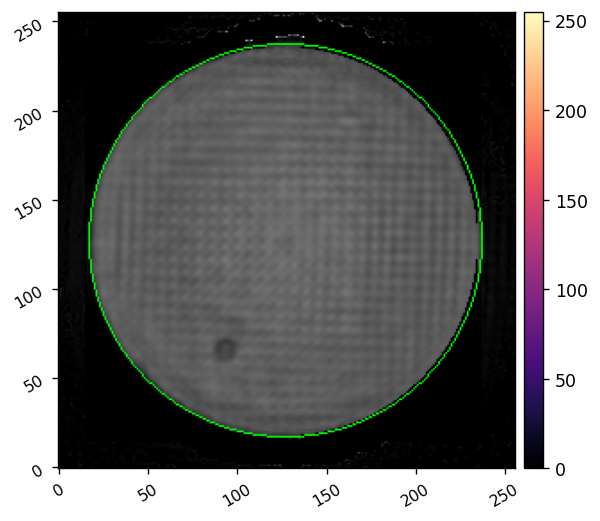

383 380 110


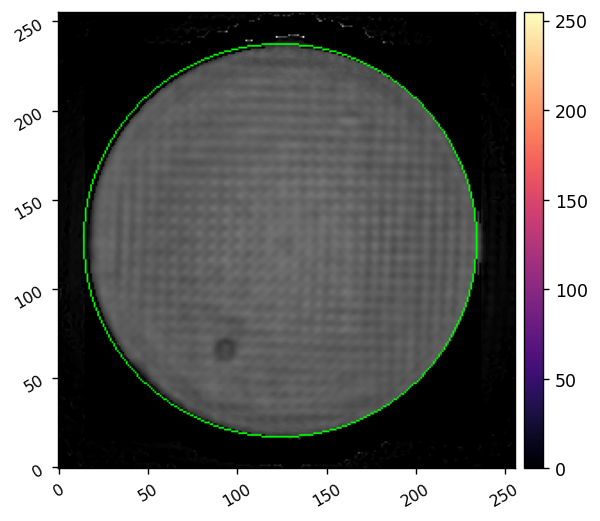

381 382 110


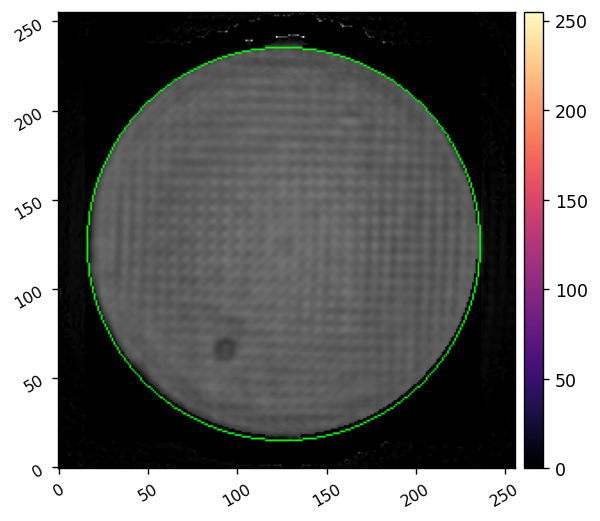

In [44]:
# Load picture and detect edges
image = img_as_ubyte(fit_ref['amp_est']/np.max(fit_ref['amp_est']))
edges = canny(image, sigma=1, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(100, 120, 1)
hough_res = hough_circle(edges, hough_radii)
# print(hough_res)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=5)

# Draw them
for center_y, center_x, radius in zip(cy, cx, radii):
    imrgb = color.gray2rgb(image)
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    imrgb[circy, circx] = (0, 255, 0)
    print(center_y, center_x, radius)
    imshow1(imrgb, figsize=(5,5), npix=256)

(216, 216)


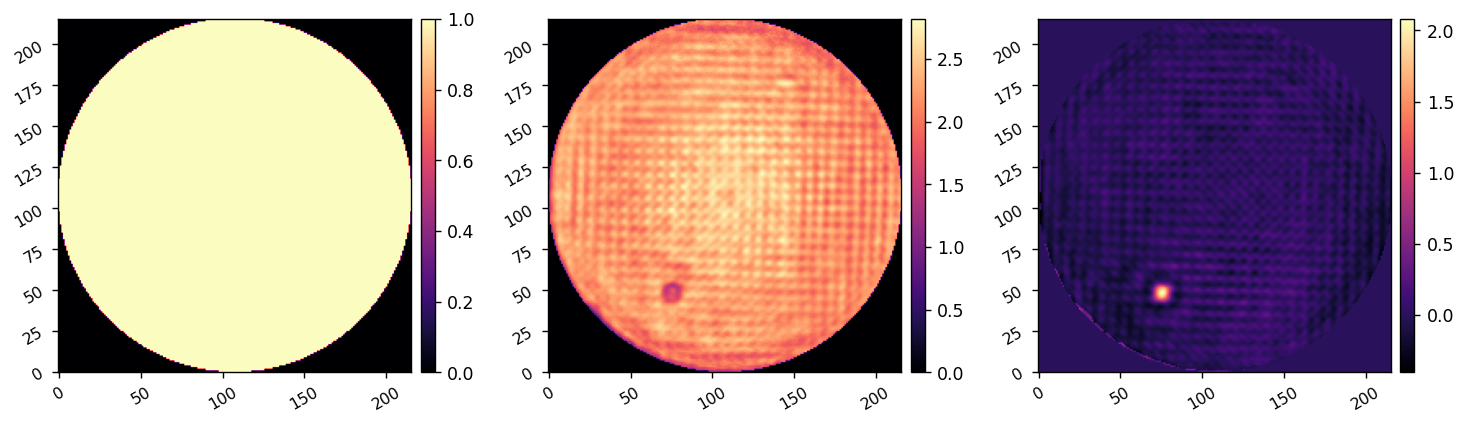

In [46]:
i = 1
center_x, center_y, radius = (cy[i], cx[i], radii[i])

amp_est_ref = fit_ref['amp_est'][center_y-radius:center_y+radius, center_x-radius:center_x+radius]
phs_est_ref = fit_ref['phase_est_ttrem'][center_y-radius:center_y+radius, center_x-radius:center_x+radius]
Nfit = amp_est_ref.shape[0]
y,x = (np.indices((Nfit, Nfit)) - Nfit/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<(radius)
print(fit_mask.shape)

amp_est_ref *= fit_mask
phs_est_ref *= fit_mask
imshow3(fit_mask, amp_est_ref, phs_est_ref)

# Process the reference data and plug into the model.

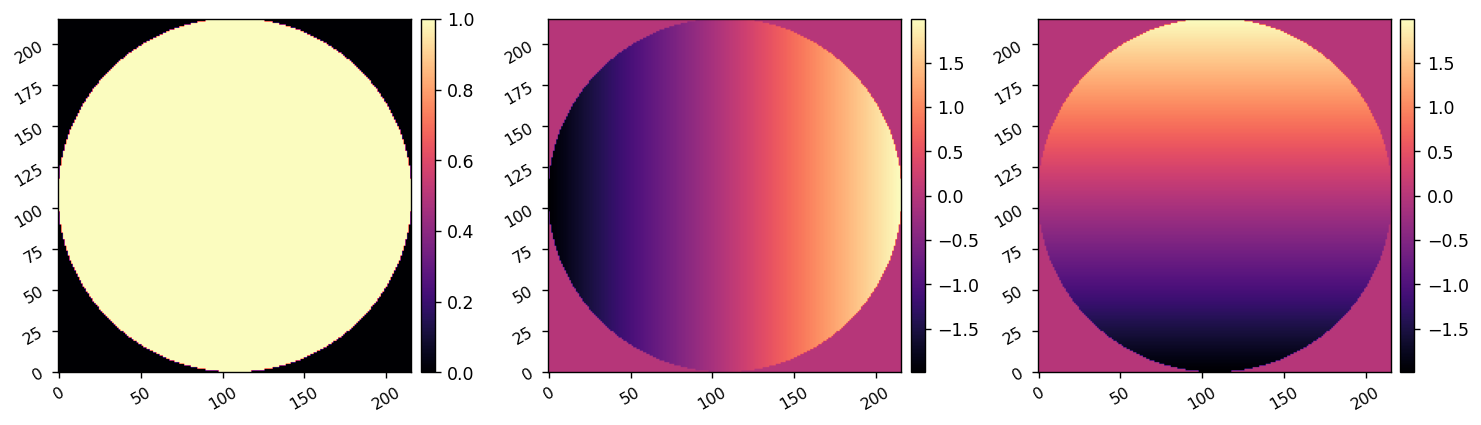

[ 0.00409278  0.00290082 -0.00320289]


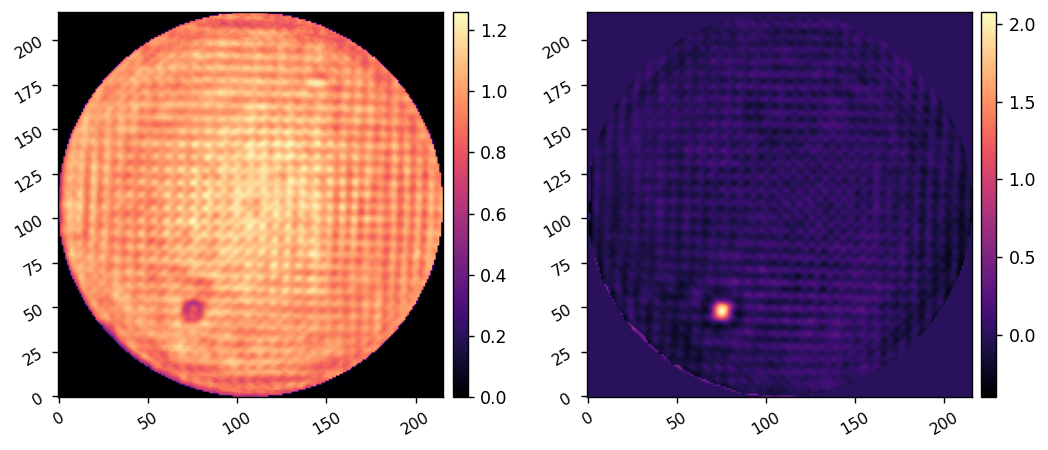

In [49]:
reload(utils)
ptt_modes = utils.create_zernike_modes(fit_mask, nmodes=3)
imshow3(ptt_modes[0], ptt_modes[1], ptt_modes[2])

ptt_coeff = utils.lstsq(ptt_modes, xp.array(phs_est_ref))
print(ptt_coeff)
ptt = ensure_np_array( xp.sum(ptt_coeff[:, None, None] * ptt_modes, axis=0) ) 
phs_est_minus_ptt = phs_est_ref - ptt

amp_est_ref /= np.mean(amp_est_ref[fit_mask])

imshow2(amp_est_ref/np.mean(amp_est_ref[fit_mask]), phs_est_minus_ptt)

(1000, 1000) (1000, 1000)


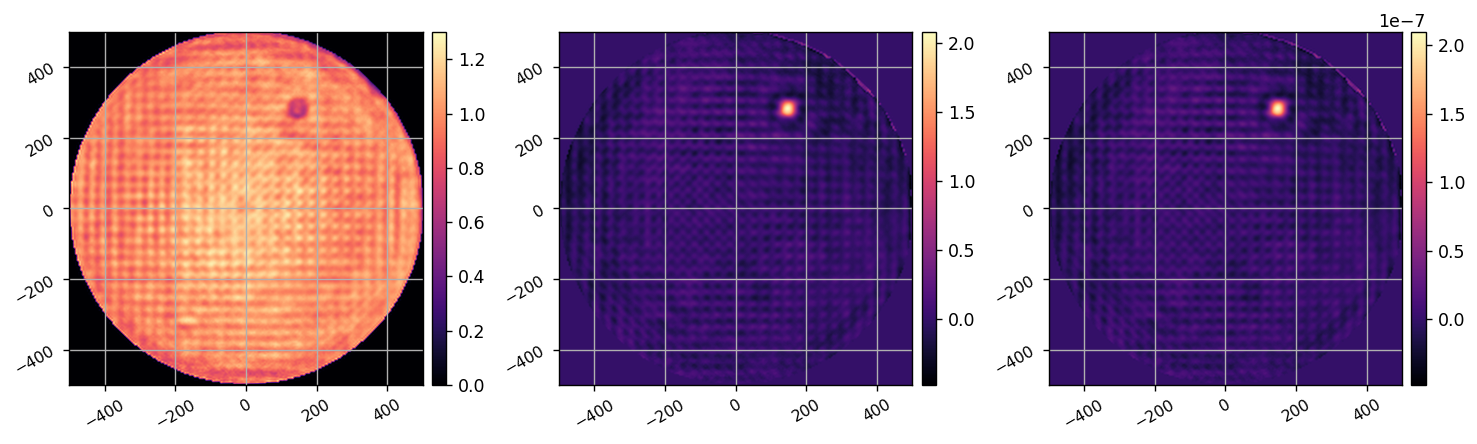

In [72]:
npix = 1001
shift = (0,0)
rotation = 179

iamp_est = utils.interp_arr(xp.array(amp_est_ref), 1/Nfit, 1/npix, order=4)
iphs_est = utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/npix, order=4)

iamp_est = xcipy.ndimage.shift(iamp_est, shift)
iphs_est = xcipy.ndimage.shift(iphs_est, shift)

iamp_est = utils.rotate_arr(iamp_est, rotation, reshape=False, order=5)
iphs_est = utils.rotate_arr(iphs_est, rotation, reshape=False, order=5)

# iamp_est = xp.flipud(iamp_est)
# iphs_est = xp.flipud(iphs_est)

iopd_est = iphs_est * wavelength / (2*np.pi)
iamp_est[iamp_est<0] = 0
processed_wfe = iamp_est * xp.exp(1j*iphs_est)
print(iamp_est.shape, iopd_est.shape)

imshow3(xp.abs(processed_wfe), xp.angle(processed_wfe), iopd_est, pxscl=1, grid=True)


In [77]:
fit_ref.keys()

dict_keys(['phase_est', 'amp_est', 'obj_val', 'fit_params', 'fitdict', 'phase_est_ttrem', 'processed_amp', 'processed_opd'])

In [78]:
fit_ref.update({
    'processed_amp':iamp_est,
    'processed_opd':iopd_est,
})
utils.save_pickle(fname, fit_ref)

Saved data to:  data/fpm_pr_data.pkl


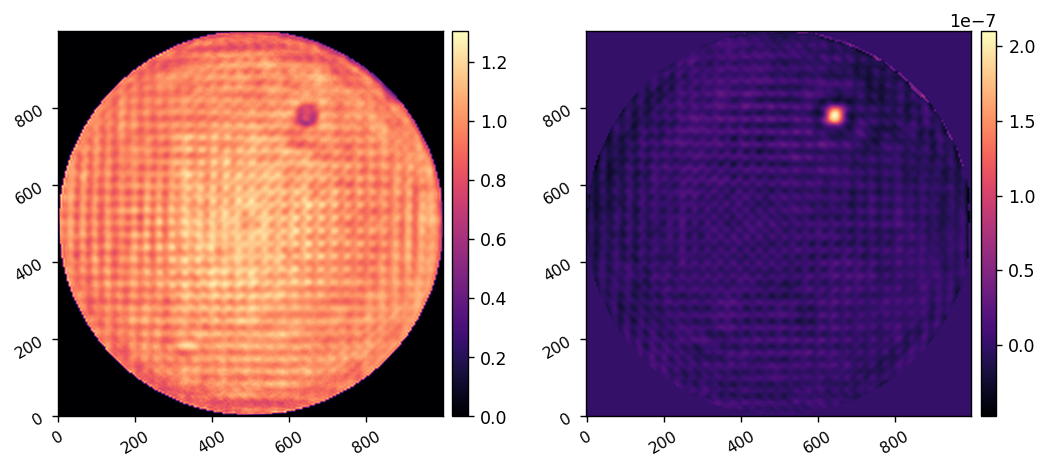

In [85]:
pr_fit = utils.load_pickle(fname)
imshow2(pr_fit['processed_amp'], pr_fit['processed_opd'])

Oversampling > 2x suggested for reliable results in Fresnel propagation.


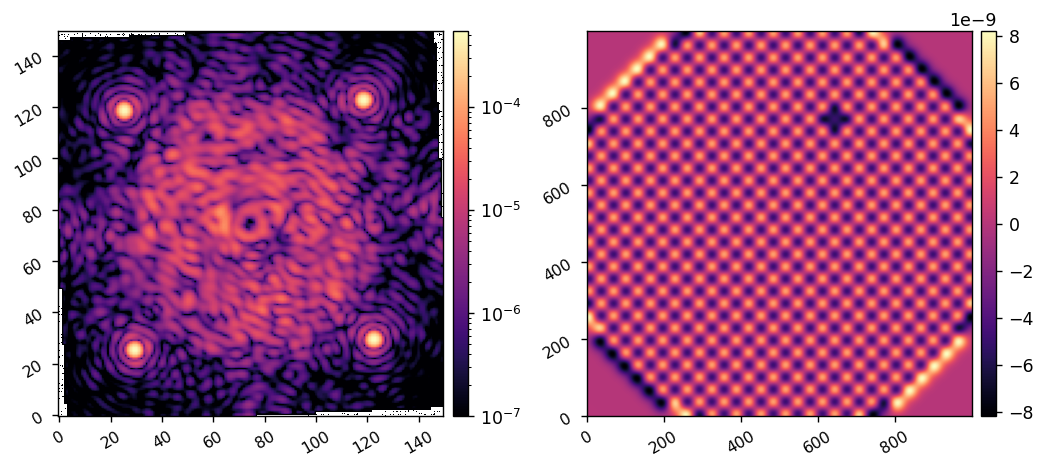

In [84]:
reload(scoobm)
M = scoobm.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0.1,0.0])*u.mm,
    # lyot_shift=np.array([0,0.35])*u.mm,
)
M.AMP = xp.array(pr_fit['processed_amp'])
M.OPD = xp.array(pr_fit['processed_opd'])

M.flip_dm = 1
M.flip_lyot_ud = 1
M.det_rotation = 177.5

fpwf = M.forward(xp.zeros(M.Nacts), M.wavelength_c, use_vortex=0, return_ints=0)
model_psf = xp.abs(fpwf)**2
M.Imax_ref = xp.max(model_psf)

waffle_command = 10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(M.dm_mask)

acts = xp.zeros(M.Nacts)
acts = waffle_command[M.dm_mask]
fpwf, E_pup, dm_phasor = M.forward(acts, M.wavelength_c, use_vortex=True, return_ints=True)
img = xp.abs(fpwf)**2
dm_opd = xp.angle(utils.pad_or_crop(dm_phasor, M.npix)) * M.wavelength_c/(4*xp.pi)
imshow2(img, dm_opd, lognorm1=True, vmin1=1e-7)